In [15]:
import numpy as np
from faceLandmarkModel import get_model, load_trained_model, compile_model
import cv2
from matplotlib import pyplot as plt
import os
import math

In [2]:
# Load the trained model
model = get_model()
compile_model(model)
load_trained_model(model)

In [3]:
# Get frontal face haar cascade
face_cascade = cv2.CascadeClassifier('cascades/haarcascade_frontalface_default.xml')

In [4]:
def matchJewel(personPath, jewelPath):
    img = cv2.imread(personPath)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        # Convert RGB data to Grayscale
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)     # Identify faces in image

    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        img_copy = np.copy(img)
        img_copy_1 = np.copy(img)
        roi_color = img_copy_1[y:y+h, x:x+w]

        width_original = roi_gray.shape[1]      # Width of region where face is detected
        height_original = roi_gray.shape[0]     # Height of region where face is detected
        img_gray = cv2.resize(roi_gray, (96, 96))       # Resize image to size 96x96
        img_gray = img_gray/255         # Normalize the image data

        img_model = np.reshape(img_gray, (1,96,96,1))   # Model takes input of shape = [batch_size, height, width, no. of channels]
        keypoints = model.predict(img_model)[0]         # Predict keypoints for the current input

        # Keypoints are saved as (x1, y1, x2, y2, ......)
        x_coords = keypoints[0::2]      # Read alternate elements starting from index 0
        y_coords = keypoints[1::2]      # Read alternate elements starting from index 1

        x_coords_denormalized = (x_coords+0.5)*width_original       # Denormalize x-coordinate
        y_coords_denormalized = (y_coords+0.5)*height_original      # Denormalize y-coordinate

        for i in range(len(x_coords)):          # Plot the keypoints at the x and y coordinates
            cv2.circle(roi_color, (x_coords_denormalized[i], y_coords_denormalized[i]), 2, (255,255,0), -1)
        plt.imshow(cv2.cvtColor(roi_color,cv2.COLOR_BGR2RGB))

        # Particular keypoints for scaling and positioning of the filter
        left_lip_coords = (int(x_coords_denormalized[11]), int(y_coords_denormalized[11]))
        right_lip_coords = (int(x_coords_denormalized[12]), int(y_coords_denormalized[12]))
        top_lip_coords = (int(x_coords_denormalized[13]), int(y_coords_denormalized[13]))
        bottom_lip_coords = (int(x_coords_denormalized[14]), int(y_coords_denormalized[14]))
        left_eye_coords = (int(x_coords_denormalized[3]), int(y_coords_denormalized[3]))
        right_eye_coords = (int(x_coords_denormalized[5]), int(y_coords_denormalized[5]))
        brow_coords = (int(x_coords_denormalized[6]), int(y_coords_denormalized[6]))

        # Scale filter according to keypoint coordinates
        beard_width = right_lip_coords[0] - left_lip_coords[0]
        glasses_width = right_eye_coords[0] - left_eye_coords[0]

        img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2BGRA)       # Used for transparency overlay of filter using the alpha channel

        # Jewel filter
        jewel_filter = cv2.imread(jewelPath, -1)
        jewel_filter = cv2.resize(jewel_filter, (glasses_width*2,glasses_width*2))
        sw,sh,sc = jewel_filter.shape

        for i in range(0,sw):       # Overlay the filter based on the alpha channel
            for j in range(0,sh):
                if jewel_filter[i,j][3] != 0:
                    img_copy[left_lip_coords[1]+int((left_lip_coords[1] -left_eye_coords[1])*.6)+i+y, left_lip_coords[0]-int((right_lip_coords[0] -left_lip_coords[0])*1.2)+j+x] = jewel_filter[i,j]
        return img_copy

In [6]:
jewels = os.listdir('jewels')
models = os.listdir('models')
print(jewels, models)

['t1.png', 't2.png', 't3.png'] ['A1.jpg', 'A2.jpg', 'K1.jpg', 'K2.jpg', 'K3.jpg', 'N1.jpg', 'N2.jpg', 'N3.jpg', 'N4.jpg', 'N5.jpg', 'S1.jpg', 'T1.jpg']


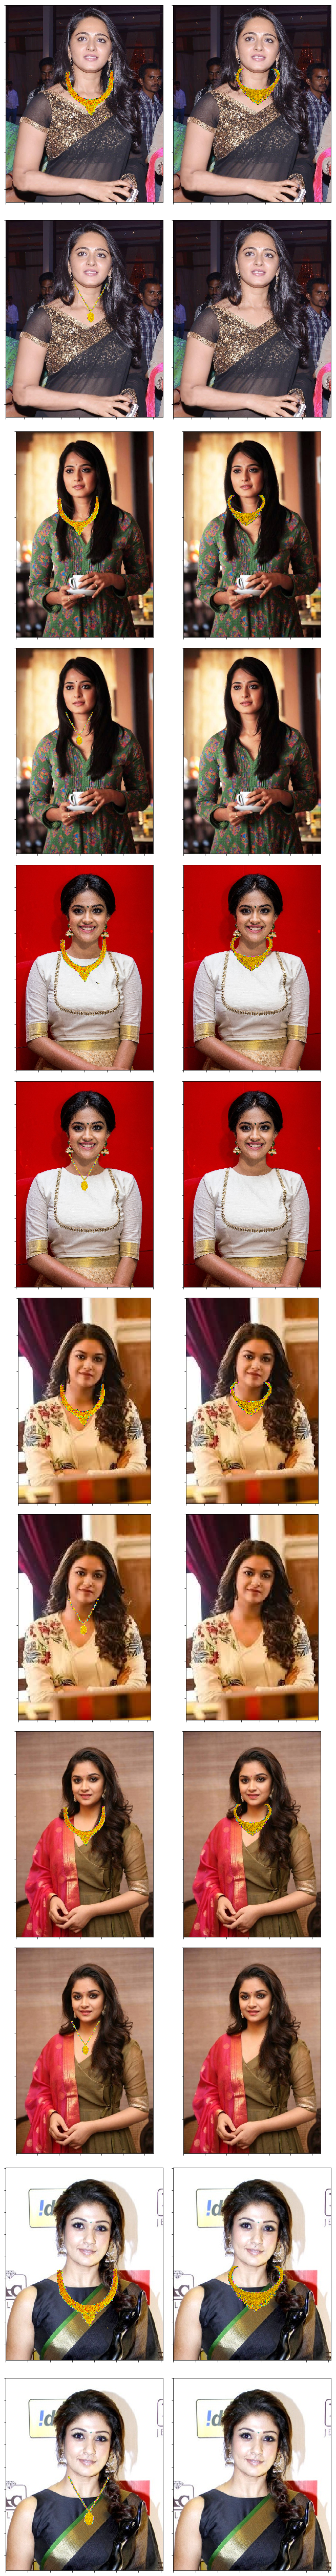

In [52]:
f, axs = plt.subplots(len(models)*math.ceil(len(jewels)//2), 2,figsize=(9,70), constrained_layout=True)
for m in range(len(models) * math.ceil(len(jewels)//2)):
    for j in range(2):
        j_idx = (m % 2)*2 + j
        m_idx = (m // 2)
        if(j_idx < len(jewels)):
            img = matchJewel('models/'+os.path.join(models[m_idx]), 'jewels/'+os.path.join(jewels[j_idx]))
            axs[m,j].imshow(cv2.cvtColor(img, cv2.COLOR_BGRA2RGB))
        else:
            if(1 == len(jewels)//2):
                axs[m,j].imshow(cv2.cvtColor(cv2.imread('models/'+os.path.join(models[m_idx])), cv2.COLOR_BGR2RGB))
        axs[m,j].set_xticklabels([])
        axs[m,j].set_yticklabels([])

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(cv2.imread('jewels/t1.png'),cv2.COLOR_BGRA2RGB))

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(cv2.imread('jewels/t2.png'),cv2.COLOR_BGRA2RGB))

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(cv2.imread('jewels/t3.png'),cv2.COLOR_BGRA2RGB))

In [ ]:
img_copy =  matchJewel('models/N1.jpg', 'jewels/t1.png')
overlayed = cv2.cvtColor(img_copy, cv2.COLOR_BGRA2RGB)
plt.figure(figsize=(40,20))
plt.imshow(overlayed)

In [ ]:
img_copy =  matchJewel('models/N1.jpg', 'jewels/t2.png')
overlayed = cv2.cvtColor(img_copy, cv2.COLOR_BGRA2RGB)
plt.figure(figsize=(40,20))
plt.imshow(overlayed)

In [ ]:
img_copy =  matchJewel('models/N1.jpg', 'jewels/t3.png')
overlayed = cv2.cvtColor(img_copy, cv2.COLOR_BGRA2RGB)
plt.figure(figsize=(40,20))
plt.imshow(overlayed)